In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

In [2]:
# 1. Preprocessing Pipeline
def preprocess_data(train_path, test_path):
    # Load datasets
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Log transform revenue
    train_df['log_revenue'] = np.log1p(train_df['revenue'])
    test_df['log_revenue'] = np.log1p(test_df['revenue'])

    # Update the genre feature columns (assuming they are from 'War' to 'Horror')
    genre_features = train_df.loc[:, 'War':'Horror'].columns.tolist()
    features = [
        'budget', 'popularity', 'runtime', 'vote_average', 'vote_count',
        'release_year', 'release_month', 'release_day', 'collection_id',
        'director_score', 'actor_score'
    ] + genre_features

    # Apply Scaler to numerical features
    scaler = MinMaxScaler()
    numerical_features = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count', 'director_score', 'actor_score']
    train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
    test_df[numerical_features] = scaler.transform(test_df[numerical_features])

    # Save scaler for future use
    # joblib.dump(scaler, 'scaler.pkl')

    # Return preprocessed data and feature list
    return train_df, test_df, features

In [3]:
# 2. Model Training Pipeline (Random Forest Regressor)
def train_model_Random_Forest(X_train, y_train, model_params=None):
    # Set default model parameters if none are provided
    if model_params is None:
        model_params = {'n_estimators': 100, 'random_state': 42}

    # Initialize and train the model
    model = RandomForestRegressor(**model_params)
    model.fit(X_train, y_train)

    # Save the trained model
    # joblib.dump(model, 'series_movie_revenue_predictor.pkl')

    return model


In [4]:
# Step 2-2. Model Training Pipeline (LightGBM Regressor)
def train_model_lightgbm(X_train, y_train, model_params=None):
    # Set default model parameters if none are provided
    if model_params is None:
        model_params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': 'mae',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'n_estimators': 100
        }

    # Initialize LightGBM model
    model = lgb.LGBMRegressor(**model_params)

    # Train the model
    model.fit(X_train, y_train)

    # Save the trained model
    # joblib.dump(model, 'series_movie_revenue_predictor_lightgbm.pkl')

    return model

In [5]:
# Step 2-2-1: LGBM Hyperparameter Tuning
def hyperparameter_tuning(X_train, y_train):
    param_grid = {
        'num_leaves': [31, 50, 70],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300]
    }
    model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='mae')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

In [6]:
# Step 3: Model Evaluation and Visualization Pipeline
def evaluate_model(model, X_test, y_test_log):
    # Predict on the test set (log scale)
    y_test_pred_log = model.predict(X_test)

    # Convert log predictions and actual values back to original scale
    y_test_pred = np.expm1(y_test_pred_log)
    y_test_actual = np.expm1(y_test_log)

    # Calculate R2 score and MAE for test set
    test_r2 = r2_score(y_test_actual, y_test_pred)
    test_mae = mean_absolute_error(y_test_actual, y_test_pred)

    # Print evaluation metrics
    print(f"Test R2 Score: {test_r2}")
    print(f"Test Mean Absolute Error: {test_mae}")

    # Plot actual vs predicted values for visual comparison
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_actual, y_test_pred, alpha=0.5)
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()],
             color='red', linestyle='--', linewidth=2)
    plt.xlabel('Actual Revenue')
    plt.ylabel('Predicted Revenue')
    plt.title('Actual vs Predicted Revenue for Test Set (Log Transformation Applied)')
    plt.show()


In [7]:
train_path = 'data/maindata_ver1.2_train.csv'
test_path = 'data/maindata_ver1.2_test.csv'

In [8]:
train_df, test_df, features = preprocess_data(train_path, test_path)

In [9]:
# Feature와 Target 분리
X_train = train_df[features]
y_train = train_df['log_revenue']
X_test = test_df[features]
y_test = test_df['log_revenue']

In [10]:
# Train the model
model = train_model_lightgbm(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1584
[LightGBM] [Info] Number of data points in the train set: 795, number of used features: 24
[LightGBM] [Info] Start training from score 18.139787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

Test R2 Score: 0.8017390958381914
Test Mean Absolute Error: 56509813.238444276


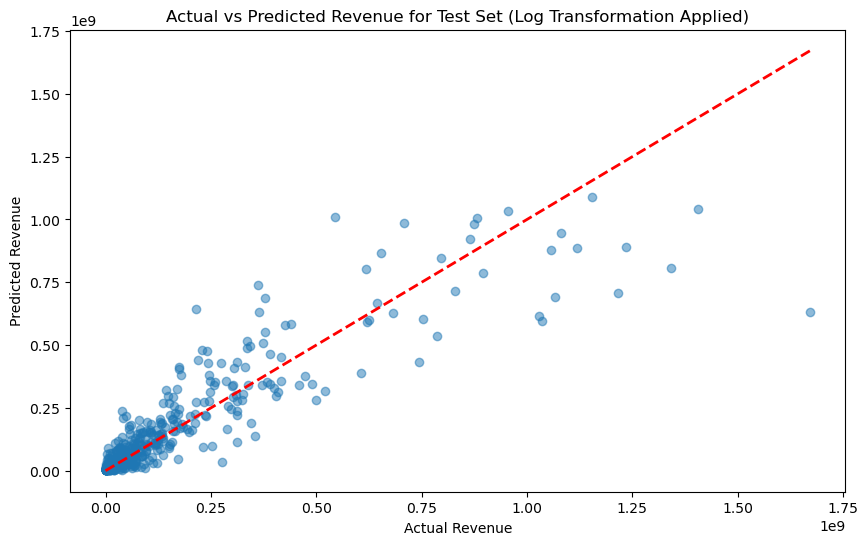

In [11]:
# Evaluate the model
evaluate_model(model, X_test, y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 530, number of used features: 24
[LightGBM] [Info] Start training from score 18.161902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

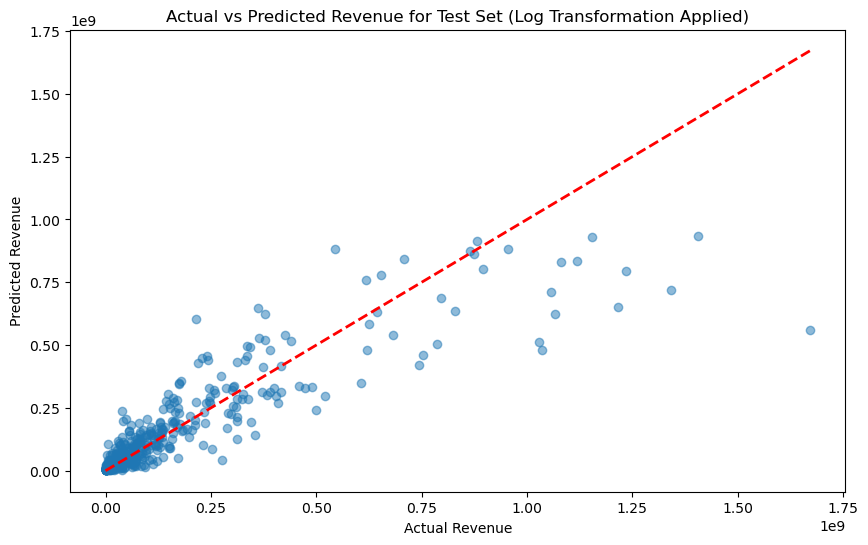

In [13]:
# Optional : Perform Hyperparameter Tuning
tuned_model = hyperparameter_tuning(X_train, y_train)
# Evaluate the tuned model
evaluate_model(tuned_model, X_test, y_test)

- 우우.. 결과가 아쉽다..

In [11]:
average_revenue_train = train_df['revenue'].mean()
average_revenue_test = test_df['revenue'].mean()

print(f"Average Revenue in Train Set: {average_revenue_train}")
print(f"Average Revenue in Test Set: {average_revenue_test}")

Average Revenue in Train Set: 196749940.80628932
Average Revenue in Test Set: 153624568.11210763
